In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

from pytorch_lightning import Trainer

In [2]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 48 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 --reduce_imbalance
--encoder_architecture cnn_gap_ts --encoder_features 20 --cf 0.001 --label_mode 48 --mode seg'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 48
Sampling 51607 (balanced) observations per epoch.
Using 632780 observations for training, 106617 for validation and 143333 observations for test


In [3]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="training_clr/clr3_UCI-HAR_21-20-19-18-17_4_48_1_bs128_lr0.001_l10_l20_cnn_gap_ts20_mlpNone_1_m48/version_0/checkpoints/epoch=22-step=9292-val_re=0.0000.ckpt")
model.eval()
print()

Input shape:  torch.Size([1, 6, 48])
Latent shape:  torch.Size([1, 80])



/home/martin/miniconda3/envs/dev2/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


In [4]:
labels = []
d = 5000
for i in range(0, d):
    labels.append(dm.ds_test[i]["label"].item())

In [5]:
scores = []
ws = 48
for i in range(0, d):
    prev = dm.ds_test[i]["series"]
    next_ = dm.ds_test[i+ws]["series"]

    prev_rep = model(prev.unsqueeze(0).cuda())
    next_rep = model(next_.unsqueeze(0).cuda())

    scores.append(((prev_rep-next_rep).square().sum()+1e-8 ).sqrt().item())

In [6]:
tr = Trainer()
tr.test(datamodule=dm, model=model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1120/1120 [00:04<00:00, 262.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.7335572838783264
       test_auroc            0.966467559337616
        test_loss                   0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_auroc': 0.966467559337616,
  'test_aupr': 0.7335572838783264}]

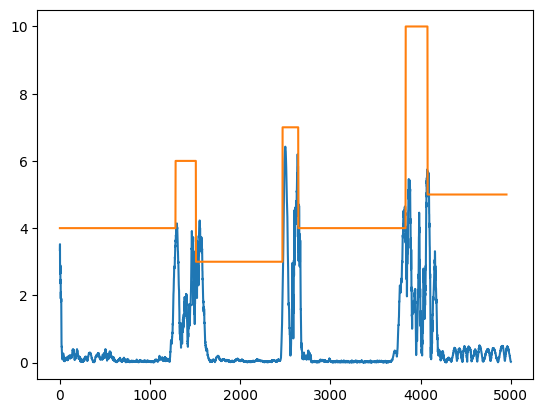

In [7]:
plt.plot(np.arange(d), model.dissimilarities[:d], np.arange(len(labels)-48), labels[48:])